<a href="https://colab.research.google.com/github/biondo999/Cfd/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [70]:
from firedrake import *
import matplotlib.pyplot as plt

import numpy as np

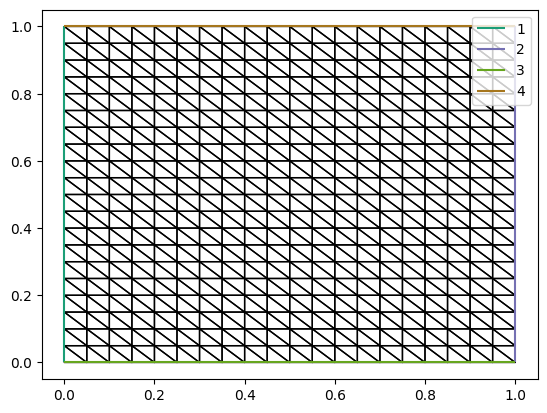

In [97]:
from firedrake import RectangleMesh

# Build the mesh
n = 20
mesh = RectangleMesh(n, n, 1, 1)

fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend()

In [98]:
# P2-P1
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

W = MixedFunctionSpace([V, Q])
print('Ndofs - velocity :',V.dim(),', pressure :',Q.dim(),', total :',W.dim())

# Finite element functions
u, p = TrialFunctions(W)
v, q = TestFunctions(W)

Ndofs - velocity : 3362 , pressure : 441 , total : 3803


In [99]:
bc1 = DirichletBC(W.sub(0), Constant((0., 0.)), 1)
bc2 = DirichletBC(W.sub(0), Constant((0., 0.)), 2)

bc3 = DirichletBC(W.sub(0), Constant((0., 0.)), 3)

bc4 = DirichletBC(W.sub(0), Constant((1., 0.)), 4)

bcs = (bc1,bc2,bc3,bc4)

In [105]:
a = inner(grad(u), grad(v)) * dx - div(v) * p * dx + q * div(u) * dx  #with + skew sym
L = inner(Constant((0.0,0.0)), v) * dx

w = Function(W)


nullsp=MixedVectorSpaceBasis(W,[W.sub(0),VectorSpaceBasis(constant=True)])   #to impose integral mean =0


firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


In [106]:
vpb=LinearVariationalProblem(a,L,w,bcs)

parameters={'ksp_type ': 'gmres ', 'pc_type ': 'none ',
'ksp_rtol ': 1.e-6, 'ksp_max_it ': 10000}

solver=LinearVariationalSolver(vpb,nullspace=nullsp,solver_parameters=parameters)


from time import perf_counter
t0=perf_counter()
solver.solve()
print('elapsed time :',perf_counter()-t0,'iter',solver.snes.ksp.getIterationNumber())

elapsed time : 2.0332911359992067 iter 1


/usr/local/lib/python3.10/dist-packages/firedrake/function.py:326: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Text(0.5, 1.0, 'velocity')

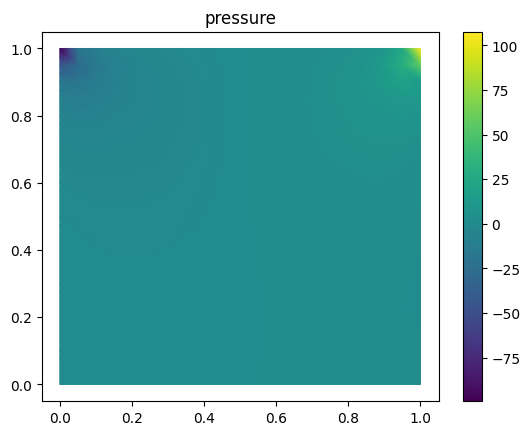

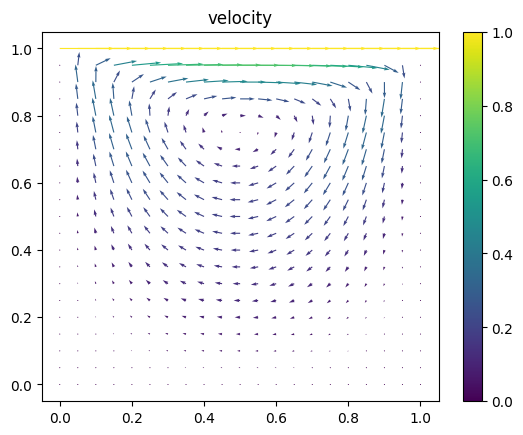

In [107]:
uh,ph=w.split()


fig, ax = plt.subplots()
col = tripcolor(ph, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver(uh, axes=ax)
plt.colorbar(col)
plt.title('velocity')


#jump of velocity on the top corners ->strong jump on the pressure

In [108]:
A=assemble(a,bcs=bcs).M.values
print(A)
print(np.linalg.cond(A))


ValueError: ignored

In [ ]:
class MyPC(firedrake.AuxiliaryOperatorPC):
  _prefix="aux"
  def form(self,pc,test,trial):
    u,p=split(trial)
    v,q=split(test)
    myPCform=inner(grad(u),grad(v))*dx+ p*q*dx
    bc1 = DirichletBC(W.sub(0), Constant((0., 0.)), 1)
    bc2 = DirichletBC(W.sub(0), Constant((0., 0.)), 2)

    bc3 = DirichletBC(W.sub(0), Constant((0., 0.)), 3)

    bc4 = DirichletBC(W.sub(0), Constant((1., 0.)), 4)

    bcs = (bc1,bc2,bc3,bc4)
    return myPCform,bcs




In [ ]:
parameters={'ksp_type ': 'gmres ', 'pc_type ': '__main__.MyPC ',
'ksp_rtol ': 1.e-6, 'ksp_max_it ': 10000,'aux':{'ksp_type':'pre_only','pc_type':'lu'}}
wh_prec=Function(W)
vpb=LinearVariationalProblem(a,L,wh_prec,bcs)

solver=LinearVariationalSolver(vpb,nullspace=nullsp,solver_parameters=parameters)


t0=perf_counter()
solver.solve()
print('elapsed time :',perf_counter()-t0,'iter',solver.snes.ksp.getIterationNumber())


In [ ]:
#calc of ei (p^-1 A)

In [ ]:
#preconditioner

parameters={'ksp_type ': 'gmres ',
'ksp_rtol ': 1.e-6, 'ksp_max_it ': 10000,'pc_type':'fieldsplit',
            'pc_fieldsplit_schur_fact_type':'full', # iwant to solve A^-1 and S^-1 exactly without approx
            'fieldsplit_0_ksp_type':'preonly','fieldslit_0_pc_type':'lu',
            'fieldsplit_1_ksp_type':'cg','fieldslit_1_pc_type':'none','fieldsplit_1__rtolksp':1e-10
            }

# in the previous lab we used 'bjacobi' that is a block pre
